# Inference demo

This notebook contains all information required to perform inference using an already trained HerdNet model.

Current notebook uses our step-by-step replica of HerdNet, to refer to original implementation and paper checkpoints you can found them  [here](https://github.com/Alexandre-Delplanque/HerdNet/)

## Model weights

We used model weights obtained after perform steps described at [experiment 2](https://github.com/lgemc/animaldet/tree/develop/experiments/HerdNet/experiment_2)

# Assumed folder structure

```
.
├── images
│   ├── image_1.jpg
│   ├── image_2.jpg
│   ├── ...
|   ├── gt.csv # file which contains groud truth points
├── infer.ipynb
```

Output detections will be saved in `detections.csv` file in the current folder.

In [55]:
# !gdown --id 1qbWC3K17Ck_GIMrXAsH9cweCHTVBNyMn

In [56]:
MODEL_PATH='./best_model_stage_2.pth'

import hashlib
def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

assert md5(MODEL_PATH) == '6c67bd01595afcebe4716c6a573132d3', "MD5 checksum does not match!"

In [57]:
import os
from animaloc.utils.seed import set_seed
import albumentations as A
from animaloc.datasets import CSVDataset
import pandas
from animaloc.data.transforms import DownSample
from animaloc.models import HerdNet, LossWrapper, load_model
from torch.utils.data import DataLoader
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
import torch
from PIL import Image

In [58]:
# Settings
IMAGES_PATH="./images"
set_seed(9292)

patch_size = 512
num_classes = 7 # 6 animal classes + 1 background
down_ratio = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


img_names = [i for i in os.listdir(IMAGES_PATH)
        if i.endswith(('.JPG','.jpg','.JPEG','.jpeg'))]
n = len(img_names)

print(f"Found {n} images for inference.")

Found 258 images for inference.


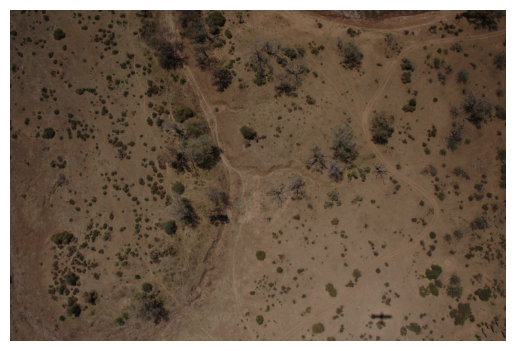

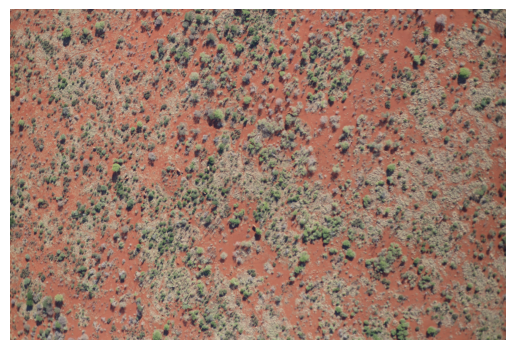

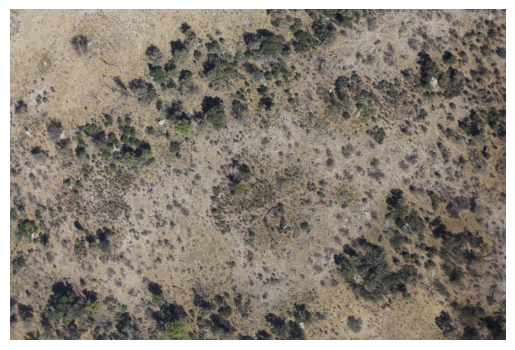

In [59]:
# First 3 images
%matplotlib inline
from matplotlib import pyplot as plt
for i in range(min(3, n)):
    img = plt.imread(os.path.join(IMAGES_PATH, img_names[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [60]:
# Inference dataset and dataloader
infer_dataset = CSVDataset(
    csv_file = f"{IMAGES_PATH}/gt.csv",
    root_dir = IMAGES_PATH,
    albu_transforms = [A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )],
    end_transforms = [DownSample(down_ratio=down_ratio, anno_type='point')]
)

test_dataloader = DataLoader(dataset = infer_dataset, batch_size = 1, shuffle = False)

In [61]:
# Model and stitcher
herdnet = HerdNet(num_classes=num_classes, down_ratio=down_ratio).to(device)
herdnet = LossWrapper(herdnet, losses=[])
herdnet = load_model(herdnet, pth_path=MODEL_PATH)


metrics = PointsMetrics(radius=20, num_classes=num_classes)

stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size,patch_size),
    overlap=160,
    down_ratio=down_ratio,
    reduction='mean',
    up=False
)

In [62]:
# Suppress warnings
import warnings

warnings.filterwarnings(
    "ignore",
    message=r"Got processor for keypoints, but no transform to process it\.",
    category=UserWarning,
    module=r"albumentations\.core\.composition"
)

In [63]:
# Performing inference
evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=IMAGES_PATH,
    header='validation',
    print_freq=10,
    lmds_kwargs = dict(kernel_size=(3,3), adapt_ts=0.3),
)

f1 = evaluator.evaluate(returns="f1_score") # required to calculate detections
print(f"F1 score: {f1}")

validation [  1/258] eta: 0:13:06 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 3.0501 data: 0.2657 max mem: 1471
validation [ 11/258] eta: 0:12:20 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 2.9859 data: 0.4352 max mem: 1471
validation [ 21/258] eta: 0:12:19 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 3.1116 data: 0.5667 max mem: 1471
validation [ 31/258] eta: 0:11:46 n: 36 recall: 0.92 precision: 0.97 f1-score: 0.94 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 3.1615 data: 0.5995 max mem: 1471
validation [ 41/258] eta: 0:11:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 3.1162 data: 0.5575 max mem: 1471
validation [ 51/258] eta: 0:10:38 n: 6 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 3.0243 data: 0.4731 max mem: 1471
validation [ 61/258] eta: 0:10:06 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0

In [64]:
# Fix a known error in HerdNet original code, described at https://github.com/Alexandre-Delplanque/HerdNet/pull/16
detections = evaluator.detections
detections["x"] = detections["x"] * 2
detections["y"] = detections["y"] * 2

In [65]:
# filter detections with null labels
detections = detections[detections['labels'].notnull()]
detections.to_csv("detections.csv", index=False)

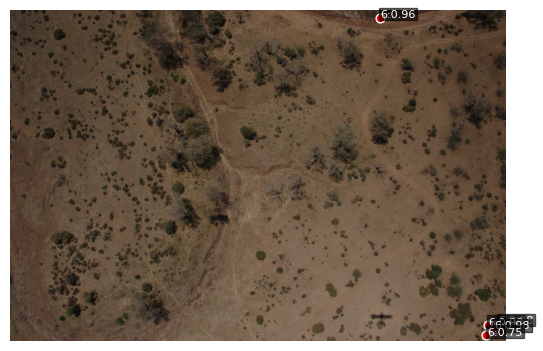

In [66]:
# Detections visualization on first image
img_name = img_names[0]
rows = detections.loc[detections['images'] == img_name]

img = Image.open(os.path.join(IMAGES_PATH, img_name))
plt.imshow(img); plt.axis('off')
plt.scatter(rows['x'], rows['y'], c='r', s=40, edgecolor='white')
for _, r in rows.iterrows():
    plt.text(r['x'] + 6, r['y'] - 6, f"{int(r['labels'])}:{r['scores']:.2f}", color='white',
             fontsize=8, bbox=dict(facecolor='black', alpha=0.6, pad=1))
plt.show()

In [67]:
# Evaluation results
results = evaluator.results
results

,class,n,recall,precision,f1_score,confusion,mae,mse,rmse,ap
0,1,675,0.850370,0.845361,0.847858,0.072698,2.189189,12.108108,3.479671,0.807609
1,2,349,0.716332,0.946970,0.815661,0.090909,3.800000,41.160000,6.415606,0.705466
2,3,477,0.836478,0.863636,0.849840,0.156448,1.018018,4.207207,2.051148,0.787073
3,4,74,0.513514,0.395833,0.447059,0.025641,1.640000,4.520000,2.126029,0.349537
4,5,36,0.694444,0.641026,0.666667,0.193548,1.533333,3.933333,1.983263,0.586885
5,6,688,0.805233,0.683107,0.739159,0.000000,2.495327,37.448598,6.119526,0.712561
6,binary,2299,0.866029,0.846874,0.856344,0.000000,1.806202,20.651163,4.544355,0.735493
